# FGD1
[Aarskog-Scott syndrome (AAS)](https://www.omim.org/entry/305400) can be caused by mutation in the FGD1 gene.


In [2]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.1


### FGD1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FGD1.

In [3]:
gene_symbol = 'FGD1'
mane_tx_id = 'NM_004463.3'
mane_protein_id = 'NP_004454.2' # FYVE, RhoGEF and PH domain-containing protein 1 [Homo sapiens]

In [4]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 48 phenopackets
Individuals Processed: 100%|██████████| 48/48 [00:43<00:00,  1.10individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
46,Short stature
45,Hypertelorism
38,Anteverted nares
36,Shawl scrotum
34,Long philtrum
32,Short nose
31,Ptosis
28,Cryptorchidism
25,Brachydactyly
23,Clinodactyly of the 5th finger


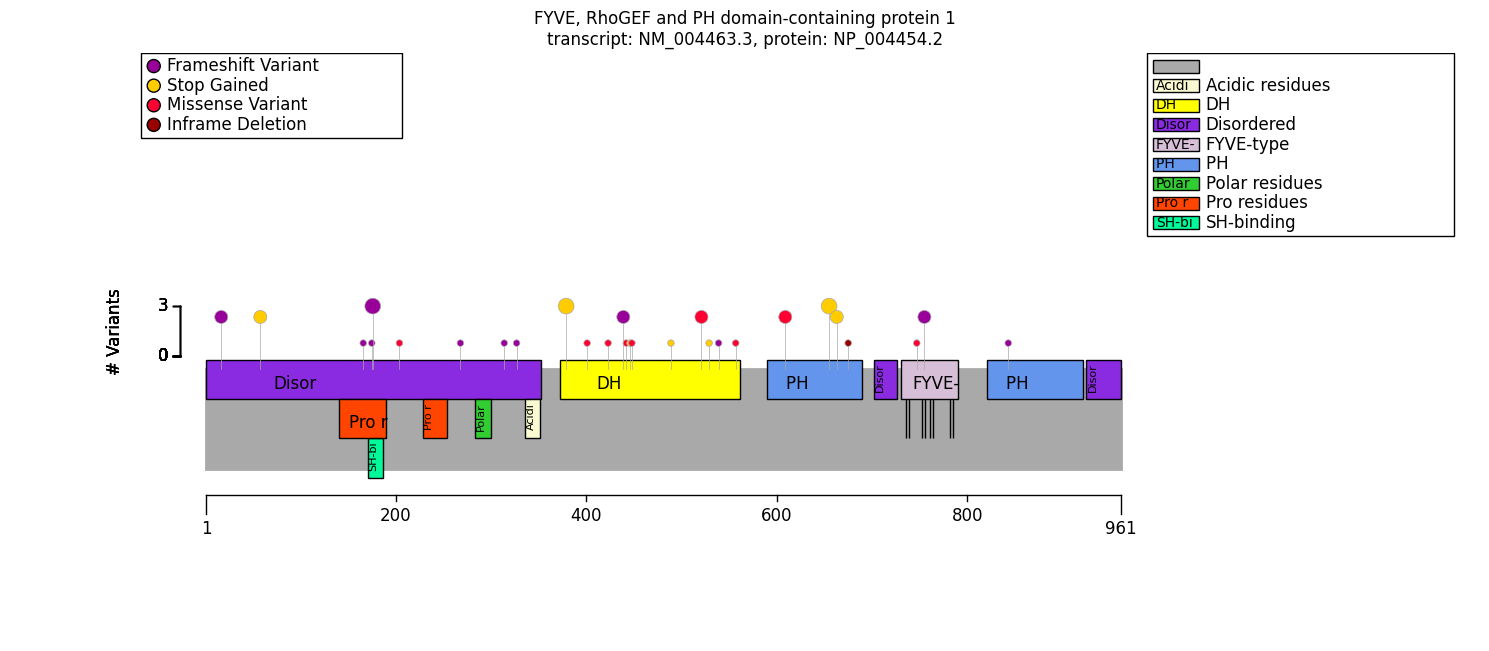

In [ ]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fgd1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fgd1_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
13,Disordered,Region,2 - 353,p.His328ThrfsTer32; p.Tyr167SerfsTer48; p.Gln59Ter; p.Leu177ThrfsTer40; p.Leu177ProfsTer40; p.Ser205Ile; p.Ala269ValfsTer91; p.Pro18ArgfsTer106; p.Pro315ArgfsTer11
5,Pro residues,Compositional bias,142 - 190,p.Tyr167SerfsTer48; p.Leu177ThrfsTer40; p.Leu177ProfsTer40
4,SH3-binding,Motif,172 - 187,p.Leu177ThrfsTer40; p.Leu177ProfsTer40
0,Pro residues,Compositional bias,230 - 254,
0,Polar residues,Compositional bias,284 - 300,
0,Acidic residues,Compositional bias,337 - 352,
16,DH,Domain,374 - 561,p.Gln490Ter; p.Trp447Ter; p.Arg443His; p.Asp540GlufsTer11; p.Ser558Trp; p.Arg449Cys; p.Arg522His; p.Asn424Asp; p.Arg402Gln; p.Glu380Ala; p.Tyr530Ter; p.Leu440ArgfsTer31; p.Glu380Ter
8,PH 1,Domain,591 - 689,p.Arg610Leu; p.Glu676del; p.Gln664Ter; p.Arg656Ter
0,Disordered,Region,703 - 726,
3,FYVE-type,Zinc finger,731 - 790,p.Lys748Glu; p.Cys756LeufsTer19


# Genotype Phenotype Correlation (GPC) Analysis

In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [10]:
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,18
HMF03,Skipping term because of a child term with the same individual counts,22
HMF08,Skipping general term,61
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,121


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense  ...          
                                                      Count  ...  p values
Broad foot [HP:0001769]                                 1/7  ...  0.000622
Cryptorchidism [HP:0000028]                            4/11  ...  0.023914
Umbilical hernia [HP:0001537]                          4/10  ...  0.141316
Ptosis [HP:0000508]                                    7/13  ...  0.155235
Short nose [HP:0003196]                               10/13  ...  0.320918
Shawl scrotum [HP:0000049]                            10/13  ...  0.352548
Downslanted palpebral fissures [HP:0000494]            5/10  ...  0.438237
Short stature [HP:0004322]                            12/13  ...  0.472518
Anteverted nares [HP:0000463]                         10/12  ...  0.607749
Widow's peak [HP:0000349]                              7/11  ...  0.687095
Hypertelorism [HP:0000316]                            13/13  ...  1.000000
Broad palm [HP:0001169]                                 7/7  ...  1.000000
Abnormal palm morphology [HP:0100871]                   9/9  ...  1.000000
Single transverse palmar crease [HP:0000954]            3/5  ...  1.000000
Growth delay [HP:0001510]                             12/12  ...  1.000000
Abnormal nasal morphology [HP:0005105]                10/10  ...  1.000000
Inguinal hernia [HP:0000023]                           6/13  ...  1.000000
Hernia of the abdominal wall [HP:0004299]               7/7  ...  1.000000
Abnormal testis morphology [HP:0000035]                 4/4  ...  1.000000
Abnormal male external genitalia morphology [HP...    11/11  ...  1.000000
Abnormal scrotum morphology [HP:0000045]              10/10  ...  1.000000
High anterior hairline [HP:0009890]                     7/7  ...  1.000000
Abnormal forehead morphology [HP:0000290]               9/9  ...  1.000000
Abnormality of the palpebral fissures [HP:0008050]      6/6  ...  1.000000
Abnormal eyelid morphology [HP:0000492]                 7/7  ...  1.000000
Abnormal ocular adnexa morphology [HP:0030669]          7/7  ...  1.000000
Slanting of the palpebral fissure [HP:0200006]          5/5  ...  1.000000
Abnormal external nose morphology [HP:0010938]        10/10  ...  1.000000
Abnormal lip morphology [HP:0000159]                  11/11  ...  1.000000
Abnormal oral cavity morphology [HP:0000163]          11/11  ...  1.000000
Brachydactyly [HP:0001156]                              6/6  ...  1.000000
Abnormal digit morphology [HP:0011297]                11/11  ...  1.000000
Abnormal appendicular skeleton morphology [HP:0...    11/11  ...  1.000000
Clinodactyly of the 5th finger [HP:0004209]             5/6  ...  1.000000
Finger clinodactyly [HP:0040019]                        5/5  ...  1.000000
Deviation of finger [HP:0004097]                        5/5  ...  1.000000
Abnormal finger morphology [HP:0001167]                 5/5  ...  1.000000
Deviation of the 5th finger [HP:0009179]                5/5  ...  1.000000
Abnormal nostril morphology [HP:0005288]              10/10  ...  1.000000
Abnormal morphology of the nasal alae [HP:0000429]    10/10  ...  1.000000
Abnormality of the philtrum [HP:0000288]              11/11  ...  1.000000
Abnormal upper lip morphology [HP:0000177]            11/11  ...  1.000000
Camptodactyly [HP:0012385]                              5/7  ...  1.000000
Flexion contracture of digit [HP:0030044]               5/5  ...  1.000000
Abnormality of joint mobility [HP:0011729]              5/5  ...  1.000000
Frontal bossing [HP:0002007]                            3/6  ...  1.000000
Long philtrum [HP:0000343]                             9/11  ...  1.000000

[47 rows x 6 columns]

In [12]:
from gpsea.analysis.predicate import protein_feature

# DH Domain
dh = protein_feature(
    feature_id="DH", protein_metadata=protein_meta
)
dh_clf = monoallelic_classifier(
    a_predicate=dh,
    b_predicate=~dh,
    a_label="DH domain",
    b_label="Other"
)
dh_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=dh_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=dh_result)

Allele group                                       DH domain  ...          
                                                       Count  ...  p values
Cryptorchidism [HP:0000028]                             5/13  ...  0.014773
Umbilical hernia [HP:0001537]                           5/12  ...  0.025565
Single transverse palmar crease [HP:0000954]             7/8  ...  0.176328
Clinodactyly of the 5th finger [HP:0004209]              5/7  ...  0.269231
Short nose [HP:0003196]                                11/14  ...  0.345875
Dental malocclusion [HP:0000689]                         1/6  ...  0.354360
Long philtrum [HP:0000343]                             12/13  ...  0.398328
Broad foot [HP:0001769]                                  4/7  ...  0.630224
Frontal bossing [HP:0002007]                             2/6  ...  0.635117
Camptodactyly [HP:0012385]                              7/10  ...  0.674369
Ptosis [HP:0000508]                                    12/16  ...  0.738494
Inguinal hernia [HP:0000023]                            7/14  ...  0.748333
Hypertelorism [HP:0000316]                             15/15  ...  1.000000
Broad palm [HP:0001169]                                  6/6  ...  1.000000
Abnormal palm morphology [HP:0100871]                  10/10  ...  1.000000
Short stature [HP:0004322]                             15/16  ...  1.000000
Growth delay [HP:0001510]                              15/15  ...  1.000000
Abnormal nasal morphology [HP:0005105]                 13/13  ...  1.000000
Hernia of the abdominal wall [HP:0004299]                8/8  ...  1.000000
Abnormal testis morphology [HP:0000035]                  5/5  ...  1.000000
Abnormal male external genitalia morphology [HP...     13/13  ...  1.000000
Shawl scrotum [HP:0000049]                             13/15  ...  1.000000
Abnormal scrotum morphology [HP:0000045]               13/13  ...  1.000000
Widow's peak [HP:0000349]                               8/11  ...  1.000000
High anterior hairline [HP:0009890]                      8/8  ...  1.000000
Abnormal forehead morphology [HP:0000290]                9/9  ...  1.000000
Abnormality of the palpebral fissures [HP:0008050]       7/7  ...  1.000000
Abnormal eyelid morphology [HP:0000492]                11/11  ...  1.000000
Abnormal ocular adnexa morphology [HP:0030669]         11/11  ...  1.000000
Downslanted palpebral fissures [HP:0000494]             6/10  ...  1.000000
Slanting of the palpebral fissure [HP:0200006]           6/6  ...  1.000000
Abnormal external nose morphology [HP:0010938]         12/12  ...  1.000000
Abnormal lip morphology [HP:0000159]                   14/14  ...  1.000000
Abnormal oral cavity morphology [HP:0000163]           15/15  ...  1.000000
Brachydactyly [HP:0001156]                               8/8  ...  1.000000
Abnormal digit morphology [HP:0011297]                 12/12  ...  1.000000
Abnormal appendicular skeleton morphology [HP:0...     14/14  ...  1.000000
Finger clinodactyly [HP:0040019]                         5/5  ...  1.000000
Deviation of finger [HP:0004097]                         5/5  ...  1.000000
Abnormal finger morphology [HP:0001167]                  5/5  ...  1.000000
Deviation of the 5th finger [HP:0009179]                 5/5  ...  1.000000
Anteverted nares [HP:0000463]                          12/14  ...  1.000000
Abnormal nostril morphology [HP:0005288]               12/12  ...  1.000000
Abnormal morphology of the nasal alae [HP:0000429]     12/12  ...  1.000000
Abnormality of the philtrum [HP:0000288]               14/14  ...  1.000000
Abnormal upper lip morphology [HP:0000177]             14/14  ...  1.000000
Flexion contracture of digit [HP:0030044]                7/7  ...  1.000000
Abnormality of joint mobility [HP:0011729]               8/8  ...  1.000000

[48 rows x 6 columns]

# Summary

In [14]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=dh_result,
    ),
)

caption = """Li et al (2024) identified a number of correlations including a lower frequency of Deformity of foot	
(8/20) with missense than with "drastic" variants (29/41); p=0.03. Multiple testing correction was not performed \\cite{PMID_38411716,PMID_33762894}. """
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [16]:
summarizer.process_latex(report=report, protein_fig=fgd1_fig)

Figure saved to ../../supplement/img/FGD1_protein_diagram-draft.pdf
Output to ../../supplement/tex/FGD1_summary_draft.tex
